In [56]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *
from src.phase_decoder_support import *
import math
import pickle
from sklearn.utils import shuffle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow as tf


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# r3 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/rollie/0210')
# ratesr3, anglesr3, phaser3 = r3.process(binsize = 0.02, multi = -2.2, override = False)
# gc.collect()

# phaser3_intermediate = drop_phase((phaser3+1), 0.75, 0.75)
# phaser3 = phaser3_intermediate[np.nonzero(phaser3_intermediate)]
# ratesr3 = ratesr3[np.nonzero(phaser3_intermediate)]



In [62]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('ocean'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)
    
    
    
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def event_tuning(phase, rates, binsize, channel = 1, negativebuffer = -.4, positivebuffer = .4, attn = 'swing', labeling = True):
    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    diff = np.diff(phase)
    
    

    stance_val = int(min(phase))
    swing_val = int(max(phase))

    
    
    stance_bins = np.count_nonzero(phase == stance_val)
    stance_inits = 0
    for i in range(phase.shape[0]):
        if ((phase[i] == stance_val) and (i == 0)) or ((phase[i] == stance_val) and (phase[i-1] != stance_val)):
            stance_inits = stance_inits + 1
    stance_mean = stance_bins / stance_inits
    
    
    swing_bins = np.count_nonzero(phase == swing_val)
    swing_inits = 0
    for i in range(phase.shape[0]):
        if ((phase[i] == swing_val) and (i == 0)) or ((phase[i] == swing_val) and (phase[i-1] != swing_val)):
            swing_inits = swing_inits + 1
    swing_mean = swing_bins / swing_inits 
    bin_size = binsize*1000
    negative_buffer = negativebuffer*1000
    positive_buffer = positivebuffer*1000
    negative_bins = int(-negative_buffer/bin_size)
    positive_bins = int(positive_buffer/bin_size)
    x_ax = np.linspace((negative_buffer),(positive_buffer),positive_bins+negative_bins)
    y_min = -60
    y_max = 60
    # y_min = 0
    # y_max = 400
    swing_time = swing_mean * bin_size
    stance_time = stance_mean * bin_size
    
    if attn == 'swing':
        inits = np.where(diff>0)[0]+1
        if labeling == True:
            ax.set_title('Swing Onset Modulation')
        ax.fill_between([-2*(stance_time+swing_time),-(swing_time+(2*stance_time))], y_min, y_max, color = 'g', alpha = 0.15)
        ax.fill_between([-(swing_time+(2*stance_time)),-(swing_time+stance_time)], y_min, y_max, color = 'r', alpha = 0.15)
        ax.fill_between([-(stance_time+swing_time+1),-stance_time], y_min, y_max, color = 'g', alpha = 0.15)
        ax.fill_between([-stance_time,0], y_min, y_max, color = 'r', alpha = 0.15)
        ax.fill_between([1,swing_time], y_min, y_max, color = 'g', alpha = 0.15)
        ax.fill_between([swing_time+1, swing_time+stance_time], y_min, y_max, color = 'r', alpha = 0.15)
        ax.fill_between([swing_time+stance_time+1,(2*swing_time)+stance_time], y_min, y_max, color = 'g', alpha = 0.15)
    elif attn == 'stance':
        inits = np.where(diff<0)[0]+1
        if labeling == True:
            ax.set_title('Stance Onset Modulation')
        ax.fill_between([-2*(stance_time+swing_time),-(stance_time+(2*swing_time))], y_min, y_max, color = 'r', alpha = 0.15)
        ax.fill_between([-(stance_time+(2*swing_time)),-(swing_time+stance_time)], y_min, y_max, color = 'g', alpha = 0.15)
        ax.fill_between([-(stance_time+swing_time),-swing_time], y_min, y_max, color = 'r', alpha = 0.15)
        ax.fill_between([-swing_time,0], y_min, y_max, color = 'g', alpha = 0.15)
        ax.fill_between([0,stance_time], y_min, y_max, color = 'r', alpha = 0.15)
        ax.fill_between([stance_time, stance_time+swing_time], y_min, y_max, color = 'g', alpha = 0.15)
        ax.fill_between([stance_time+swing_time,(2*stance_time)+swing_time], y_min, y_max, color = 'r', alpha = 0.15)
    else:
        raise ValueError('Define Alignment')
    
    ax.set_ylim(y_min, y_max)
    if channel == 'all':
        for i in range(0,32):
            stack_stack = []
            for init in inits:
                if init-negative_bins >= 0 and init+positive_bins < rates.shape[0]:
                    stack_stack.append(rates[init-negative_bins:init+positive_bins,i])
            channel_rates = np.array(stack_stack)
            channel_mean = np.mean(channel_rates)
            mean_rates = np.mean(channel_rates, axis = 0)
            deflection = mean_rates - channel_mean
            # deflection = mean_rates
            ax.bar(x_ax, deflection,width = 20, align = 'edge', alpha = 1/8)
        ax.axvline(x=0, color = 'k', linestyle = '--')
        ax.axhline(y=0, color = 'k')
        ax.set_xlim([negative_buffer,positive_buffer])
        if labeling == True:
            ax.set_ylabel('Spike Rate [crossings/sec]')
            ax.set_xlabel('Time [ms]')
    else:
        stack_stack = []
        for init in inits:
            if init-negative_bins >= 0 and init+positive_bins < rates.shape[0]:
                stack_stack.append(rates[init-negative_bins:init+positive_bins,channel])
        channel_rates = np.array(stack_stack)
        channel_mean = np.mean(channel_rates)
        mean_rates = np.mean(channel_rates, axis = 0)
        deflection = mean_rates - channel_mean
        # deflection = mean_rates
        ax.bar(x_ax, deflection,width = 20, align = 'edge')
        ax.axvline(x=0, color = 'k', linestyle = '--')
        ax.axhline(y=0, color = 'k')
        ax.set_xlim([negative_buffer,positive_buffer])
        
        if labeling == True:
            ax.set_ylabel('Spike Rate [crossings/sec]')
            ax.set_xlabel('Time [ms]')
    return

In [34]:
# event_tuning(phaser3, ratesr3, 0.02, channel = 'all',negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)


In [35]:
r1 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/rollie/0120')
ratesr1, anglesr1, phaser1 = r1.process(binsize = 0.02)
gc.collect()
r2 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/rollie/0203')
ratesr2, anglesr2, phaser2 = r2.process(binsize = 0.02)
gc.collect()
r3 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/rollie/0210')
ratesr3, anglesr3, phaser3 = r3.process(binsize = 0.02)
gc.collect()
r4 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/rollie/0216')
ratesr4, anglesr4, phaser4 = r4.process(binsize = 0.02)
gc.collect()
r5 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/rollie/0224')
ratesr5, anglesr5, phaser5 = r5.process(binsize = 0.02)
gc.collect()

read from t=0s to t=290.08s


KeyboardInterrupt: 

In [ ]:
m1 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/meepo/923')
ratesm1, anglesm1, phasem1 = m1.process(binsize = 0.02)
gc.collect()
m2 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/meepo/1004')
ratesm2, anglesm2, phasem2 = m2.process(binsize = 0.02)
gc.collect()
m3 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/meepo/1010')
ratesm3, anglesm3, phasem3 = m3.process(binsize = 0.02)
gc.collect()
m4 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/trimmed_results/meepo/1017')
ratesm4, anglesm4, phasem4 = m4.process(binsize = 0.02)
gc.collect()

In [36]:
phaser1t_intermediate = drop_phase((phaser1+1), 0.75, 0.75)
phaser1t = phaser1t_intermediate[np.nonzero(phaser1t_intermediate)]
ratesr1t = ratesr1[np.nonzero(phaser1t_intermediate)]

phaser2t_intermediate = drop_phase((phaser2+1), 0.75, 0.75)
phaser2t = phaser2t_intermediate[np.nonzero(phaser2t_intermediate)]
ratesr2t = ratesr2[np.nonzero(phaser2t_intermediate)]

phaser3t_intermediate = drop_phase((phaser3+1), 0.75, 0.75)
phaser3t = phaser3t_intermediate[np.nonzero(phaser3t_intermediate)]
ratesr3t = ratesr3[np.nonzero(phaser3t_intermediate)]

phaser4t_intermediate = drop_phase((phaser4+1), 0.75, 0.75)
phaser4t = phaser4t_intermediate[np.nonzero(phaser4t_intermediate)]
ratesr4t = ratesr4[np.nonzero(phaser4t_intermediate)]

phaser5t_intermediate = drop_phase((phaser5+1), 0.75, 0.75)
phaser5t = phaser5t_intermediate[np.nonzero(phaser5t_intermediate)]
ratesr5t = ratesr5[np.nonzero(phaser5t_intermediate)]


# phaser1s_intermediate = drop_phase((phaser1+1), 0, 10)
# phaser1s = phaser1s_intermediate[np.nonzero(phaser1s_intermediate)]
# ratesr1s = ratesr1[np.nonzero(phaser1s_intermediate)]

# phaser2s_intermediate = drop_phase((phaser2+1), 0, 10)
# phaser2s = phaser2s_intermediate[np.nonzero(phaser2s_intermediate)]
# ratesr2s = ratesr2[np.nonzero(phaser2s_intermediate)]

# phaser3s_intermediate = drop_phase((phaser3+1), 0, 10)
# phaser3s = phaser3s_intermediate[np.nonzero(phaser3s_intermediate)]
# ratesr3s = ratesr3[np.nonzero(phaser3s_intermediate)]

# phaser4s_intermediate = drop_phase((phaser4+1), 0, 10)
# phaser4s = phaser4s_intermediate[np.nonzero(phaser4s_intermediate)]
# ratesr4s = ratesr4[np.nonzero(phaser4s_intermediate)]

# phaser5s_intermediate = drop_phase((phaser5+1), 0, 10)
# phaser5s = phaser5s_intermediate[np.nonzero(phaser5s_intermediate)]
# ratesr5s = ratesr5[np.nonzero(phaser5s_intermediate)]



phasem1t_intermediate = drop_phase((phasem1+1), 0.75, 0.75)
phasem1t = phasem1t_intermediate[np.nonzero(phasem1t_intermediate)]
ratesm1t = ratesm1[np.nonzero(phasem1t_intermediate)]

phasem2t_intermediate = drop_phase((phasem2+1), 0.75, 0.75)
phasem2t = phasem2t_intermediate[np.nonzero(phasem2t_intermediate)]
ratesm2t = ratesm2[np.nonzero(phasem2t_intermediate)]

phasem3t_intermediate = drop_phase((phasem3+1), 0.75, 0.75)
phasem3t = phasem3t_intermediate[np.nonzero(phasem3t_intermediate)]
ratesm3t = ratesm3[np.nonzero(phasem3t_intermediate)]

phasem4t_intermediate = drop_phase((phasem4+1), 0.75, 0.75)
phasem4t = phasem4t_intermediate[np.nonzero(phasem4t_intermediate)]
ratesm4t = ratesm4[np.nonzero(phasem4t_intermediate)]


# phasem1s_intermediate = drop_phase((phasem1+1), 0, 10)
# phasem1s = phasem1s_intermediate[np.nonzero(phasem1s_intermediate)]
# ratesm1s = ratesm1[np.nonzero(phasem1s_intermediate)]

# phasem2s_intermediate = drop_phase((phasem2+1), 0, 10)
# phasem2s = phasem2s_intermediate[np.nonzero(phasem2s_intermediate)]
# ratesm2s = ratesm2[np.nonzero(phasem2s_intermediate)]

# phasem3s_intermediate = drop_phase((phasem3+1), 0, 10)
# phasem3s = phasem3s_intermediate[np.nonzero(phasem3s_intermediate)]
# ratesm3s = ratesm3[np.nonzero(phasem3s_intermediate)]

# phasem4s_intermediate = drop_phase((phasem4+1), 0, 10)
# phasem4s = phasem4s_intermediate[np.nonzero(phasem4s_intermediate)]
# ratesm4s = ratesm4[np.nonzero(phasem4s_intermediate)]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
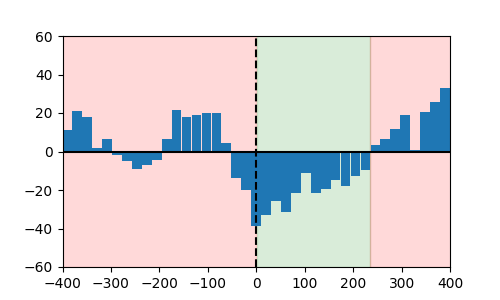

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
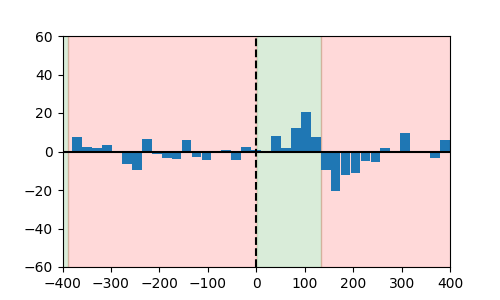

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
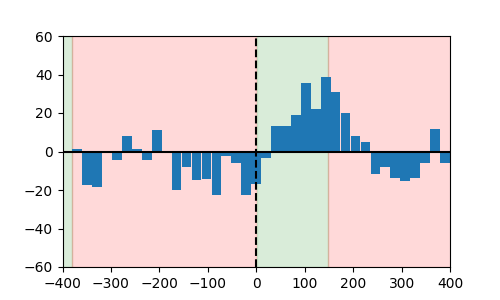

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
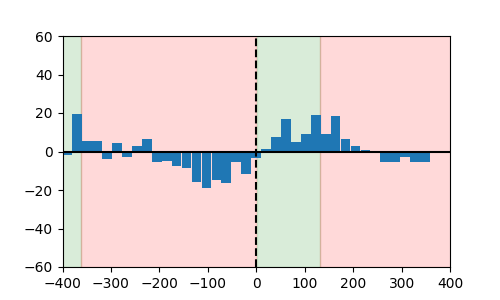

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
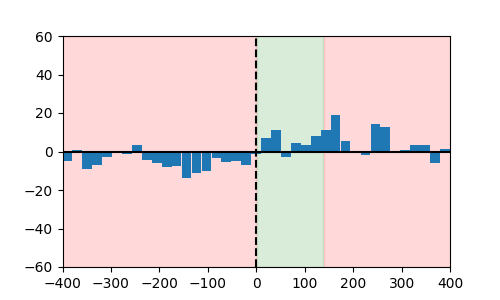

In [41]:
event_tuning(phaser1t, ratesr1t, 0.02, channel = 3, attn= 'swing', labeling = False)
event_tuning(phaser2t, ratesr2t, 0.02, channel = 3, attn= 'swing', labeling= False)
event_tuning(phaser3t, ratesr3t, 0.02, channel = 3, attn= 'swing', labeling= False)
event_tuning(phaser4t, ratesr4t, 0.02, channel = 3, attn= 'swing', labeling= False)
event_tuning(phaser5t, ratesr5t, 0.02, channel = 3, attn= 'swing', labeling= False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
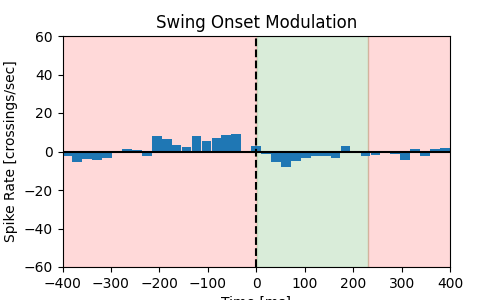

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
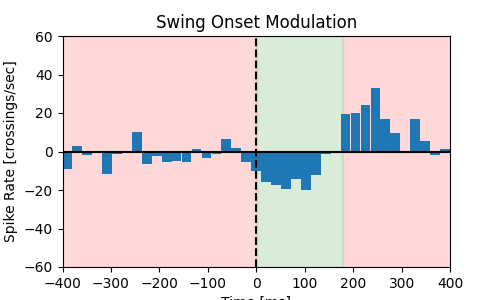

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
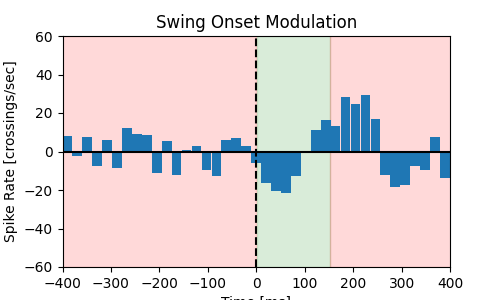

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
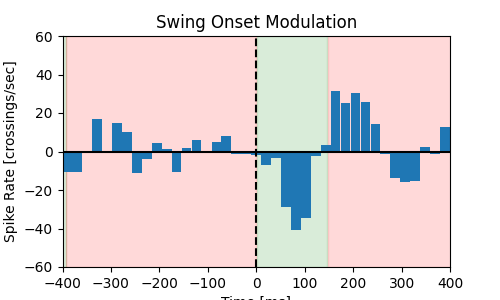

In [38]:
event_tuning(phasem1t, ratesm1t, 0.02, channel = 11, attn= 'swing', labeling = True)
event_tuning(phasem2t, ratesm2t, 0.02, channel = 11,attn= 'swing', labeling= True)
event_tuning(phasem3t, ratesm3t, 0.02, channel = 11,attn= 'swing', labeling= True)
event_tuning(phasem4t, ratesm4t, 0.02, channel = 11,attn= 'swing', labeling= True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
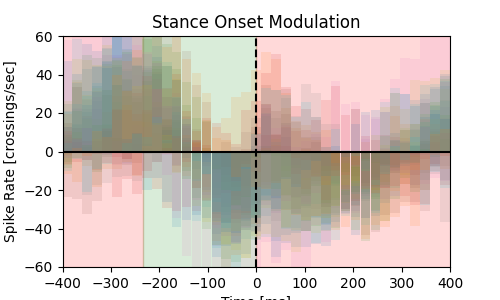

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
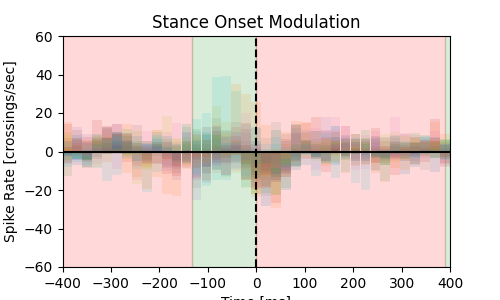

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
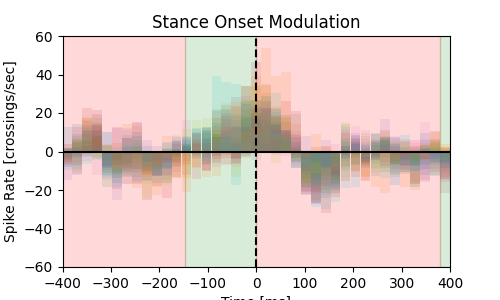

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
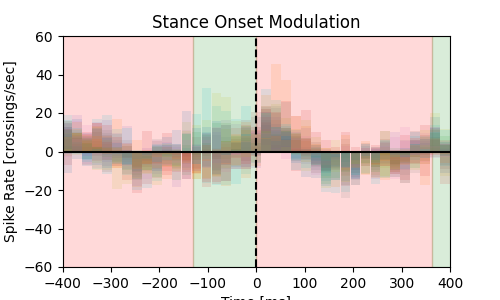

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
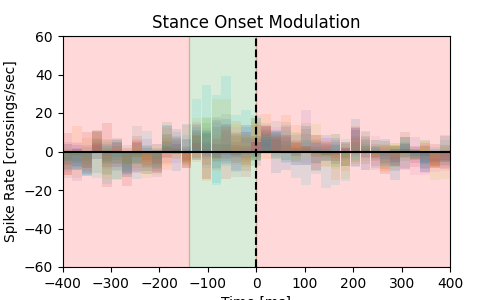

In [39]:
event_tuning(phaser1t, ratesr1t, 0.02, channel = 'all', attn= 'stance', labeling = True)
event_tuning(phaser2t, ratesr2t, 0.02, channel = 'all',attn= 'stance', labeling= True)
event_tuning(phaser3t, ratesr3t, 0.02, channel = 'all',attn= 'stance', labeling= True)
event_tuning(phaser4t, ratesr4t, 0.02, channel = 'all',attn= 'stance', labeling= True)
event_tuning(phaser5t, ratesr5t, 0.02, channel = 'all',attn= 'stance', labeling= True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
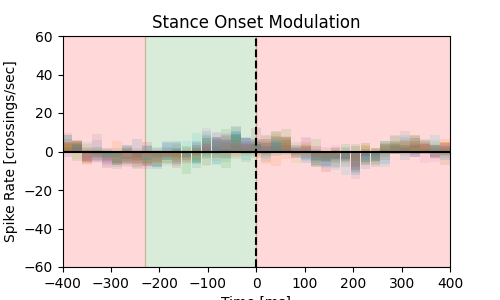

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
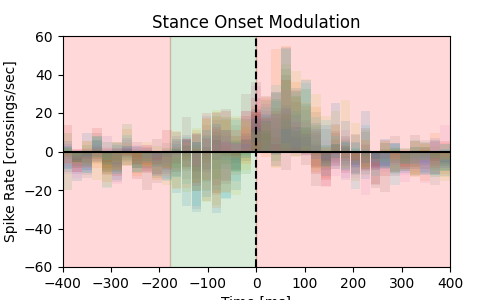

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
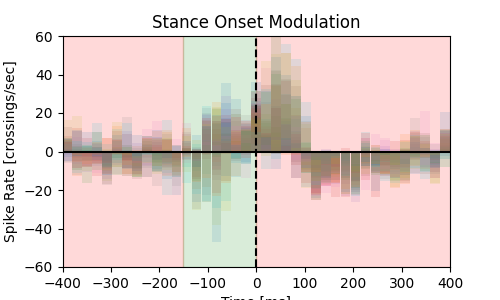

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
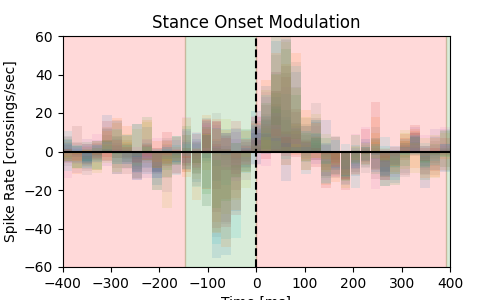

In [40]:
event_tuning(phasem1t, ratesm1t, 0.02, channel = 'all', attn= 'stance', labeling = True)
event_tuning(phasem2t, ratesm2t, 0.02, channel = 'all',attn= 'stance', labeling= True)
event_tuning(phasem3t, ratesm3t, 0.02, channel = 'all',attn= 'stance', labeling= True)
event_tuning(phasem4t, ratesm4t, 0.02, channel = 'all',attn= 'stance', labeling= True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
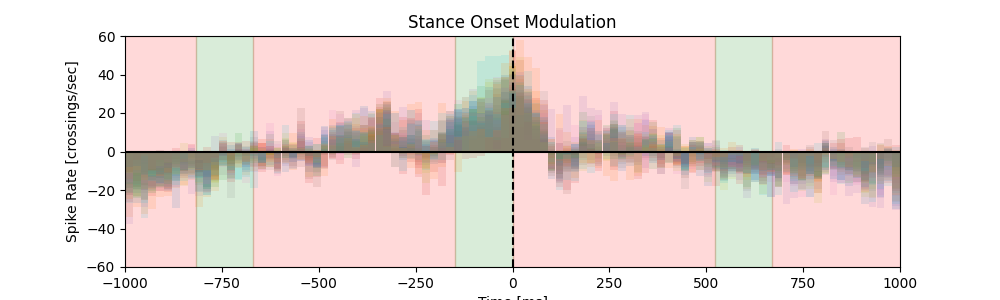

In [27]:
event_tuning(phaser3, ratesr3, 0.02, channel = 'all',negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
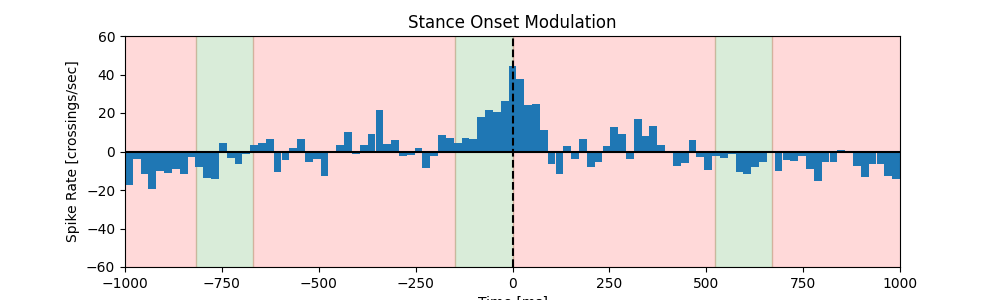

In [28]:
event_tuning(phaser3, ratesr3, 0.02, channel = 1,negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
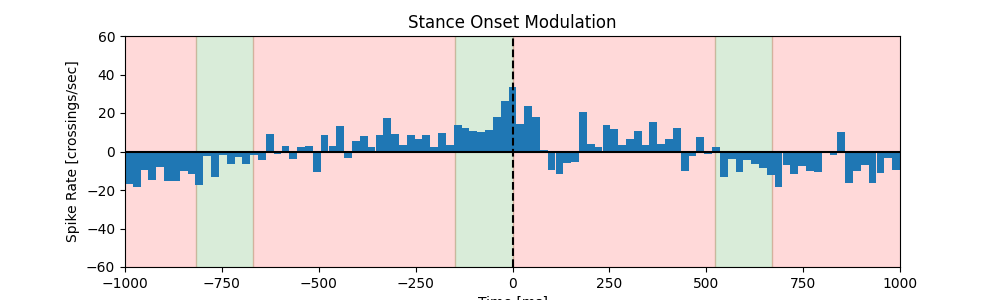

In [29]:
event_tuning(phaser3, ratesr3, 0.02, channel = 2,negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
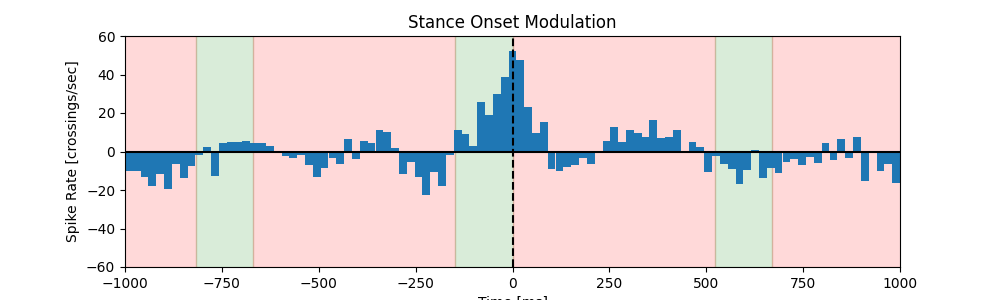

In [30]:
event_tuning(phaser3, ratesr3, 0.02, channel = 3,negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
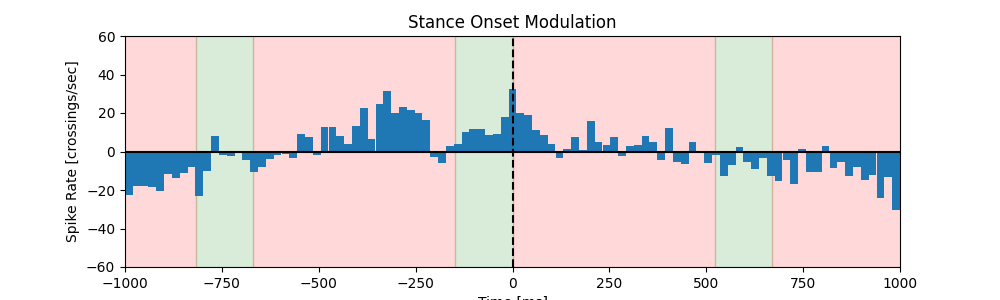

In [31]:
event_tuning(phaser3, ratesr3, 0.02, channel = 4,negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
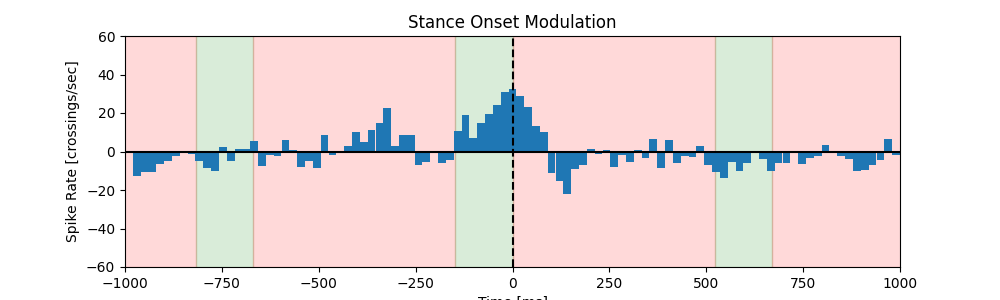

In [32]:
event_tuning(phaser3, ratesr3, 0.02, channel = 5,negativebuffer = -1, positivebuffer = 1, attn= 'stance', labeling = True)

In [49]:
r3.data['angle_names']

['ankle', 'knee', 'hip', 'limbfoot', 'elbow', 'shoulder', 'forelimb']

(76.05949893413796, 179.17851557742785)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
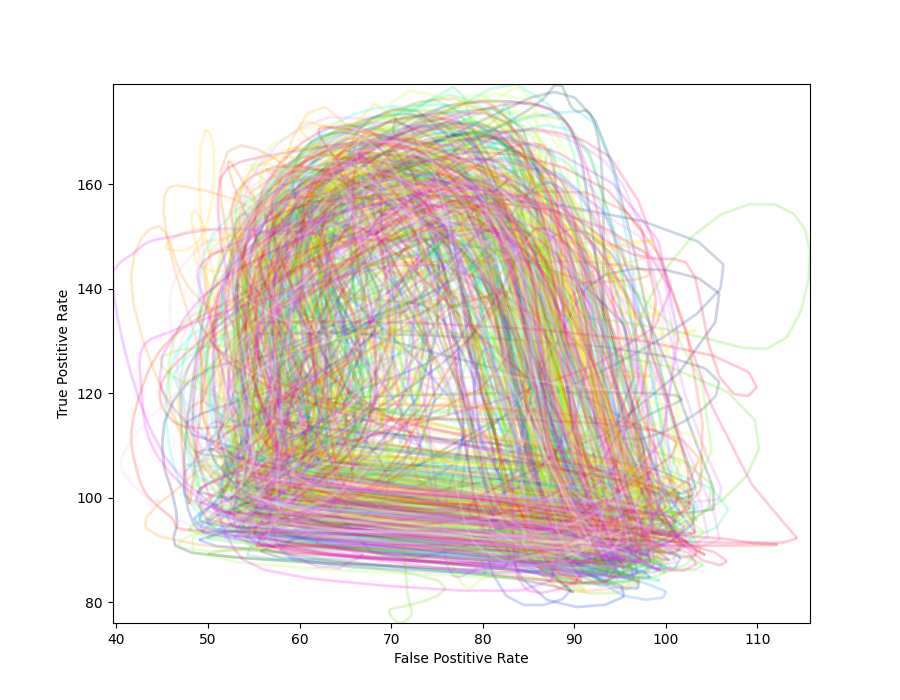

In [96]:
fore1 = r1.data['angles'][0][:,6]
hind1 = r1.data['angles'][0][:,1]
fig, ax = plt.subplots(figsize=(9,7))
_ = colorline(x=hind1, y=fore1, z=None, cmap=plt.get_cmap('gist_ncar'), linewidth=2, alpha = 0.2)
ax.set_xlim(min(hind1), max(hind1))
ax.set_ylim(min(fore1), max(fore1))

(41.01717813658962, 126.22138936140205)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
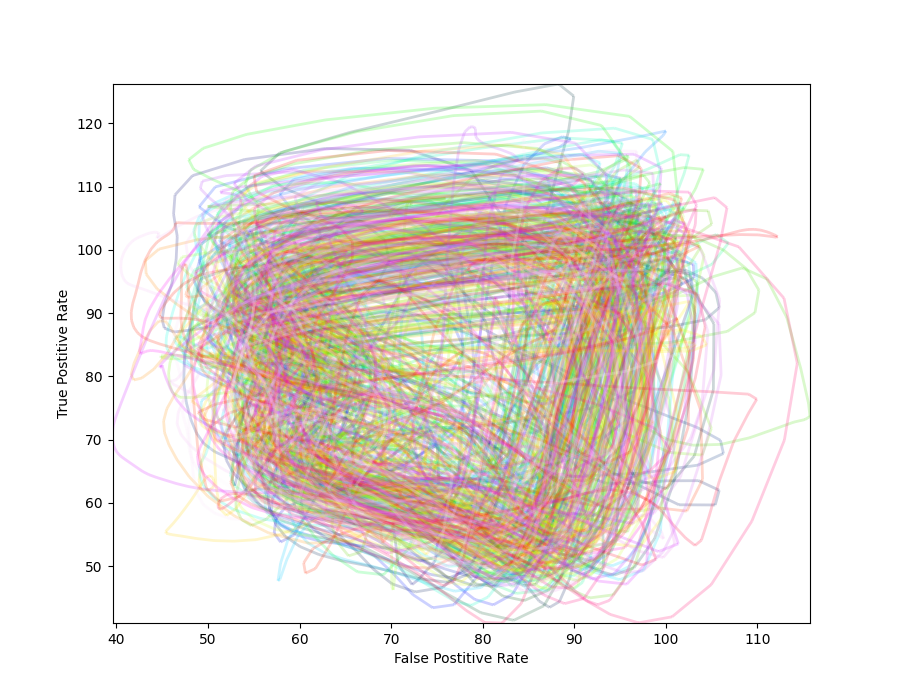

In [101]:
fore1 = r1.data['angles'][0][:,4]
hind1 = r1.data['angles'][0][:,1]
fig, ax = plt.subplots(figsize=(9,7))
_ = colorline(x=hind1, y=fore1, z=None, cmap=plt.get_cmap('gist_ncar'), linewidth=2, alpha = 0.2)
ax.set_xlim(min(hind1), max(hind1))
ax.set_ylim(min(fore1), max(fore1))

(41.01717813658962, 126.22138936140205)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
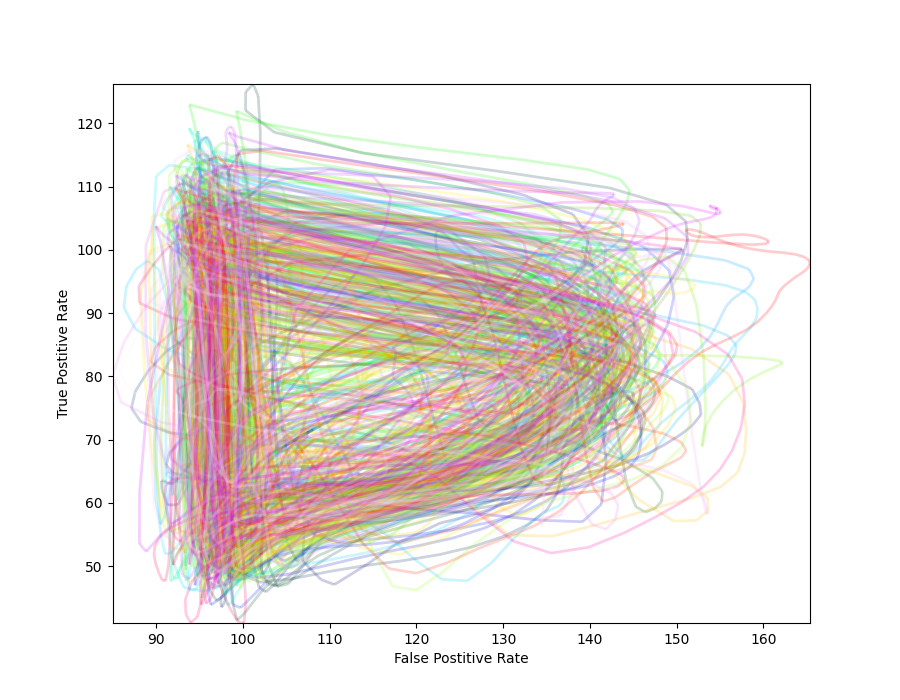

In [99]:
fore1 = r1.data['angles'][0][:,4]
hind1 = r1.data['angles'][0][:,3]
fig, ax = plt.subplots(figsize=(9,7))
_ = colorline(x=hind1, y=fore1, z=None, cmap=plt.get_cmap('gist_ncar'), linewidth=2, alpha = 0.2)
ax.set_xlim(min(hind1), max(hind1))
ax.set_ylim(min(fore1), max(fore1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
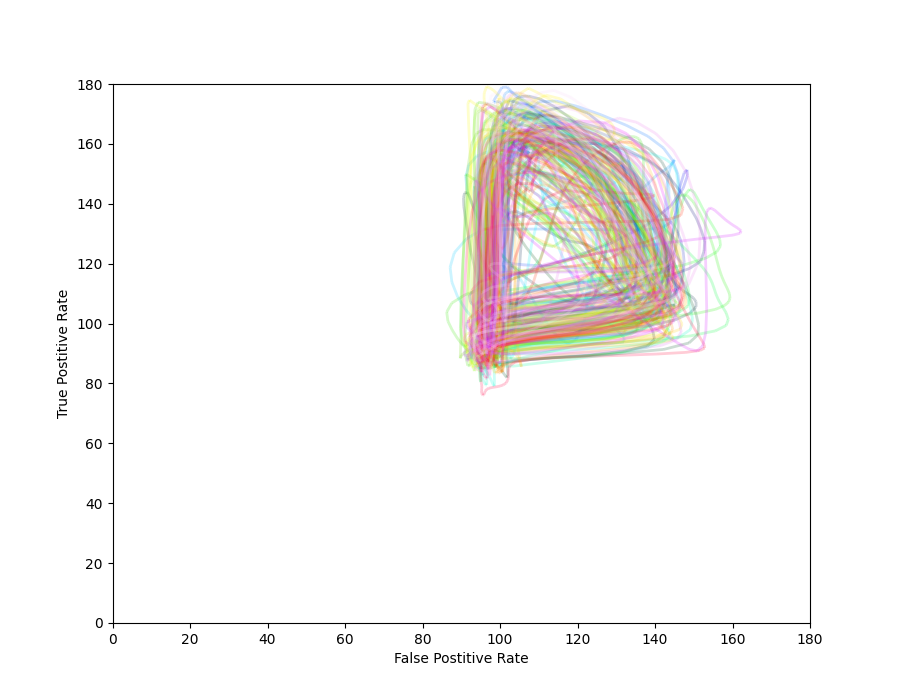

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
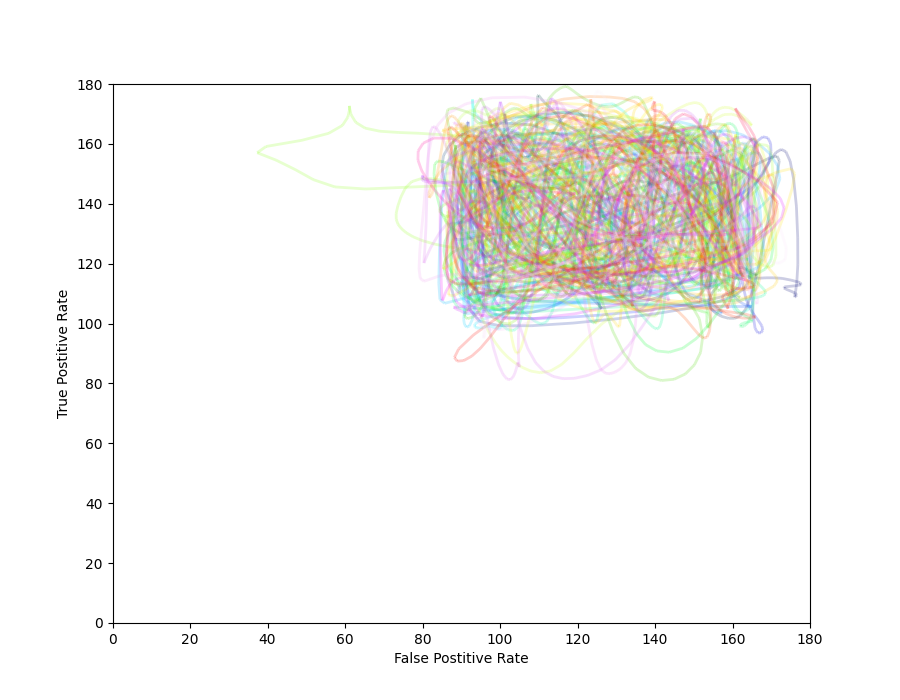

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
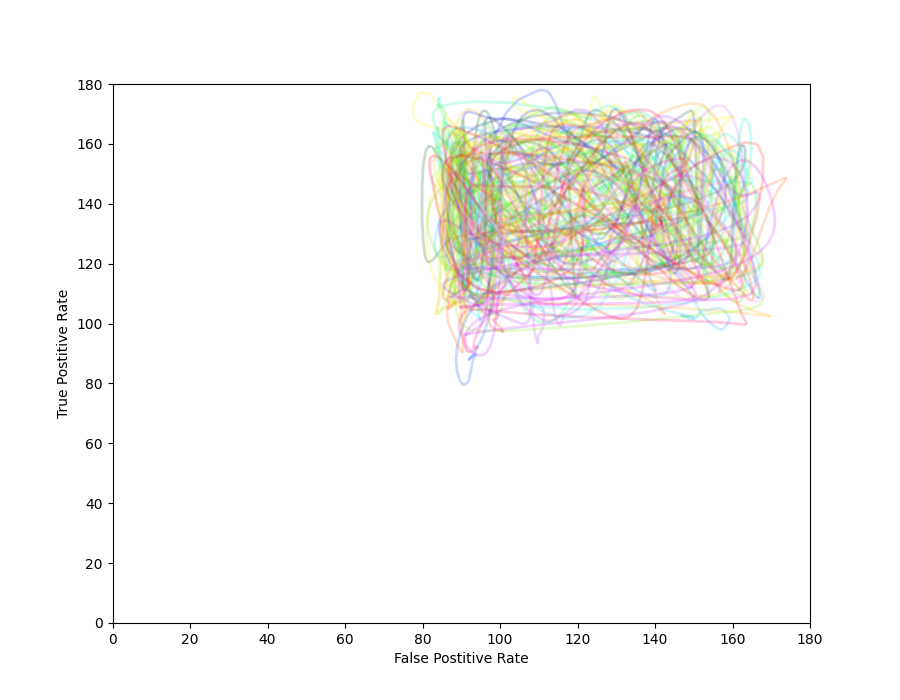

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
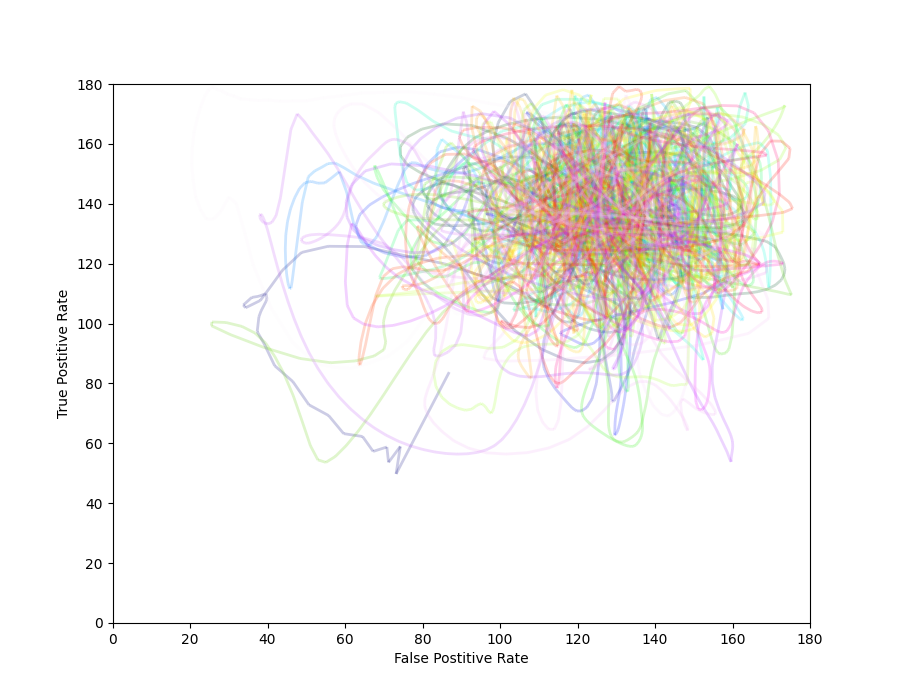

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
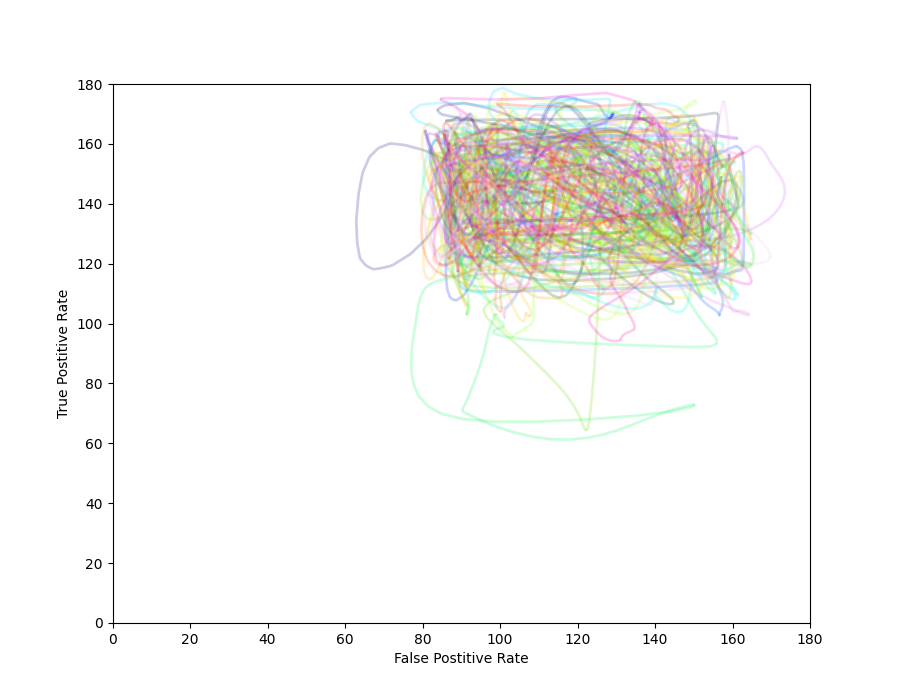

In [112]:
def call_color(x,y):
    fig, ax = plt.subplots(figsize=(9,7))
    _ = colorline(x=x, y=y, z=None, cmap=plt.get_cmap('gist_ncar'), linewidth=2, alpha = 0.2)
    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(min(y), max(y))
    ax.set_xlim(0, 180)
    ax.set_ylim(0, 180)

fore1 = r1.data['angles'][0][:,6]
hind1 = r1.data['angles'][0][:,3]
call_color(hind1[:int(len(hind1)/2)], fore1[:int(len(hind1)/2)])

fore2 = r2.data['angles'][0][:,6]
hind2 = r2.data['angles'][0][:,3]
call_color(hind2[:int(len(hind2)/2)], fore2[:int(len(hind2)/2)])

fore3 = r3.data['angles'][0][:,6]
hind3 = r3.data['angles'][0][:,3]
call_color(hind3[:int(len(hind3)/2)], fore3[:int(len(hind3)/2)])

fore4 = r4.data['angles'][0][:,6]
hind4 = r4.data['angles'][0][:,3]
call_color(hind4, fore4)

fore5 = r5.data['angles'][0][:,6]
hind5 = r5.data['angles'][0][:,3]
call_color(hind5, fore5)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
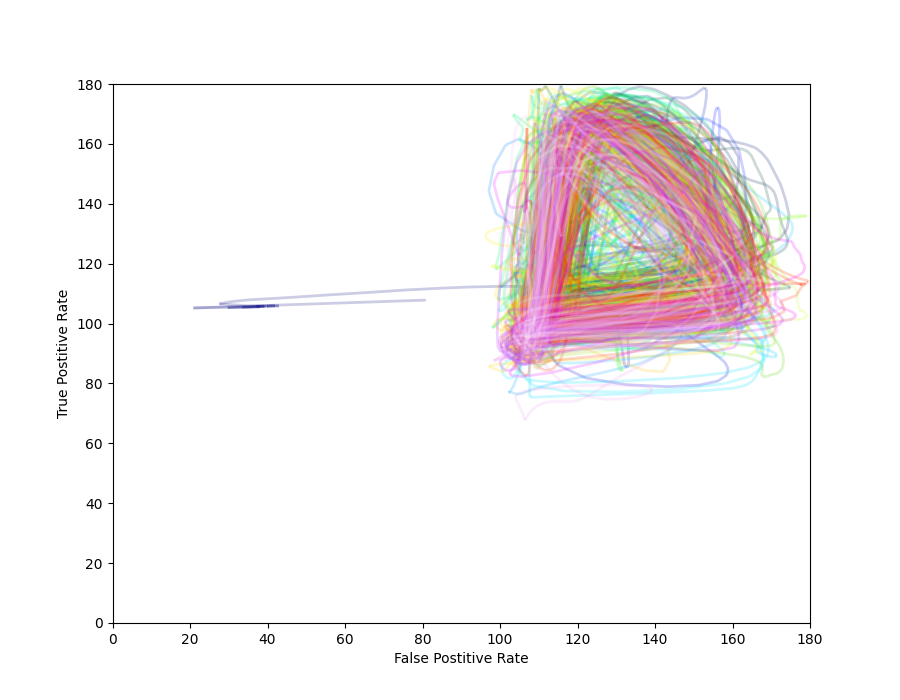

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
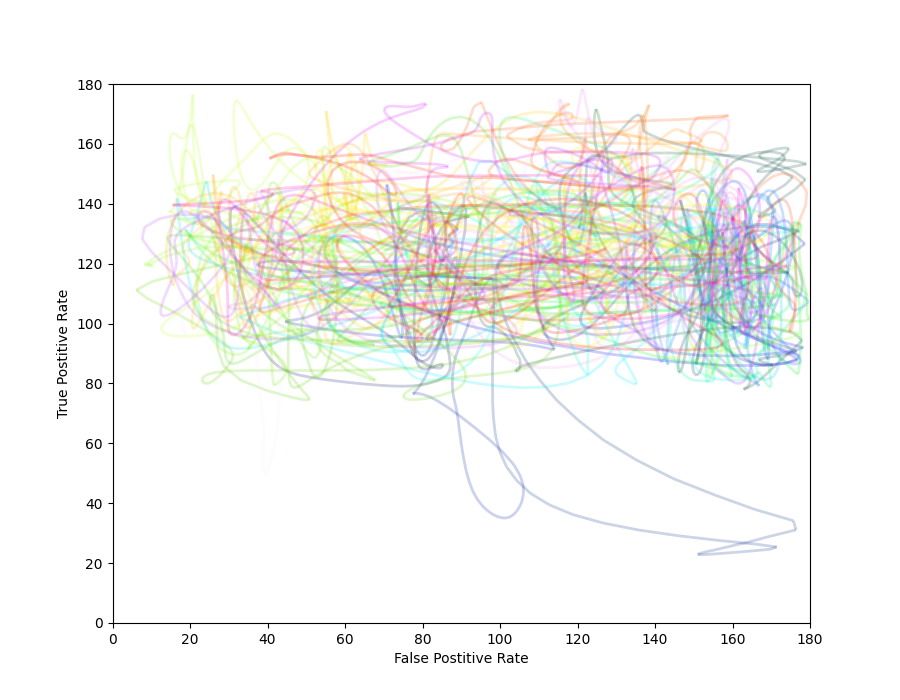

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
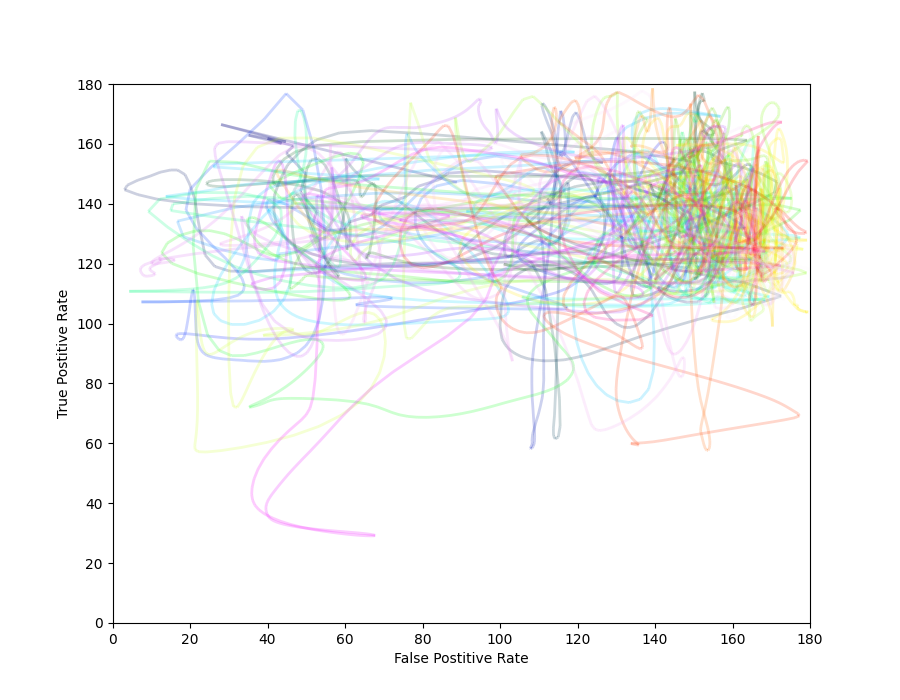

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
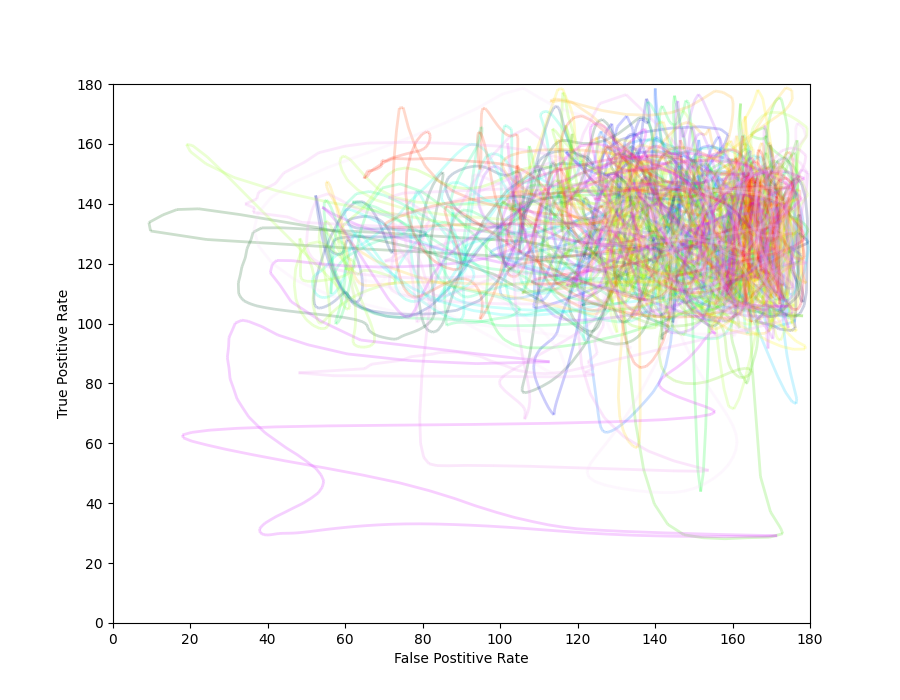

In [108]:
fore1 = m1.data['angles'][0][:,6]
hind1 = m1.data['angles'][0][:,3]
call_color(hind1, fore1)

fore2 = m2.data['angles'][0][:,6]
hind2 = m2.data['angles'][0][:,3]
call_color(hind2, fore2)

fore3 = m3.data['angles'][0][:,6]
hind3 = m3.data['angles'][0][:,3]
call_color(hind3, fore3)

fore4 = m4.data['angles'][0][:,6]
hind4 = m4.data['angles'][0][:,3]
call_color(hind4, fore4)